In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns

In [2]:
from PIL import Image
from keras.preprocessing.image import img_to_array, array_to_img, load_img
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
import cv2 as cv
import os
import random

In [3]:
import tensorflow as tf

In [4]:
# create dictionary of relationship between label and sign
categories = {0:"0",1:"1",2:"2",3:"3",4:"4",5:"5",6:"6",7:"7",8:"8",9:"9",
              10:"a",11:"b",12:"c",13:"d",14:"e",15:"f",16:"g",17:"h",18:"i",
              19:"j",20:"k",21:"l",22:"m",23:"n",24:"o",25:"p",26:"q",27:"r",
              28:"s",29:"t",30:"u",31:"v",32:"w",33:"x",34:"y",35:"z"}

In [5]:
# create dataframe from images in directory
data_path = 'asl_dataset'
root_dir = os.listdir(data_path)
file_list = []
image_list = []
label_list = []

for directory in root_dir:
    directory_path = f"{data_path}/{directory}"
    if not os.path.isdir(directory_path) or directory=='asl_dataset':
        continue
    for files in os.listdir(f"{data_path}/{directory}"):
        file_path = f"{data_path}/{directory}/{files}"
        file_list.append(file_path)
        label_list.append(directory)
        img = plt.imread(file_path)
        image_list.append(np.array(img))
df = pd.DataFrame({'file':file_list,'image':image_list,'label':label_list})
df

,file,image,label
0,asl_dataset/0/hand1_0_bot_seg_1_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
1,asl_dataset/0/hand1_0_bot_seg_2_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
2,asl_dataset/0/hand1_0_bot_seg_3_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
3,asl_dataset/0/hand1_0_bot_seg_4_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
4,asl_dataset/0/hand1_0_bot_seg_5_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",0
...,...,...,...
2510,asl_dataset/z/hand5_z_dif_seg_1_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",z
2511,asl_dataset/z/hand5_z_dif_seg_2_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",z
2512,asl_dataset/z/hand5_z_dif_seg_3_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",z
2513,asl_dataset/z/hand5_z_dif_seg_4_cropped.jpeg,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",z


C:\Users\91961\AppData\Local\Temp\ipykernel_9200\4195460350.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


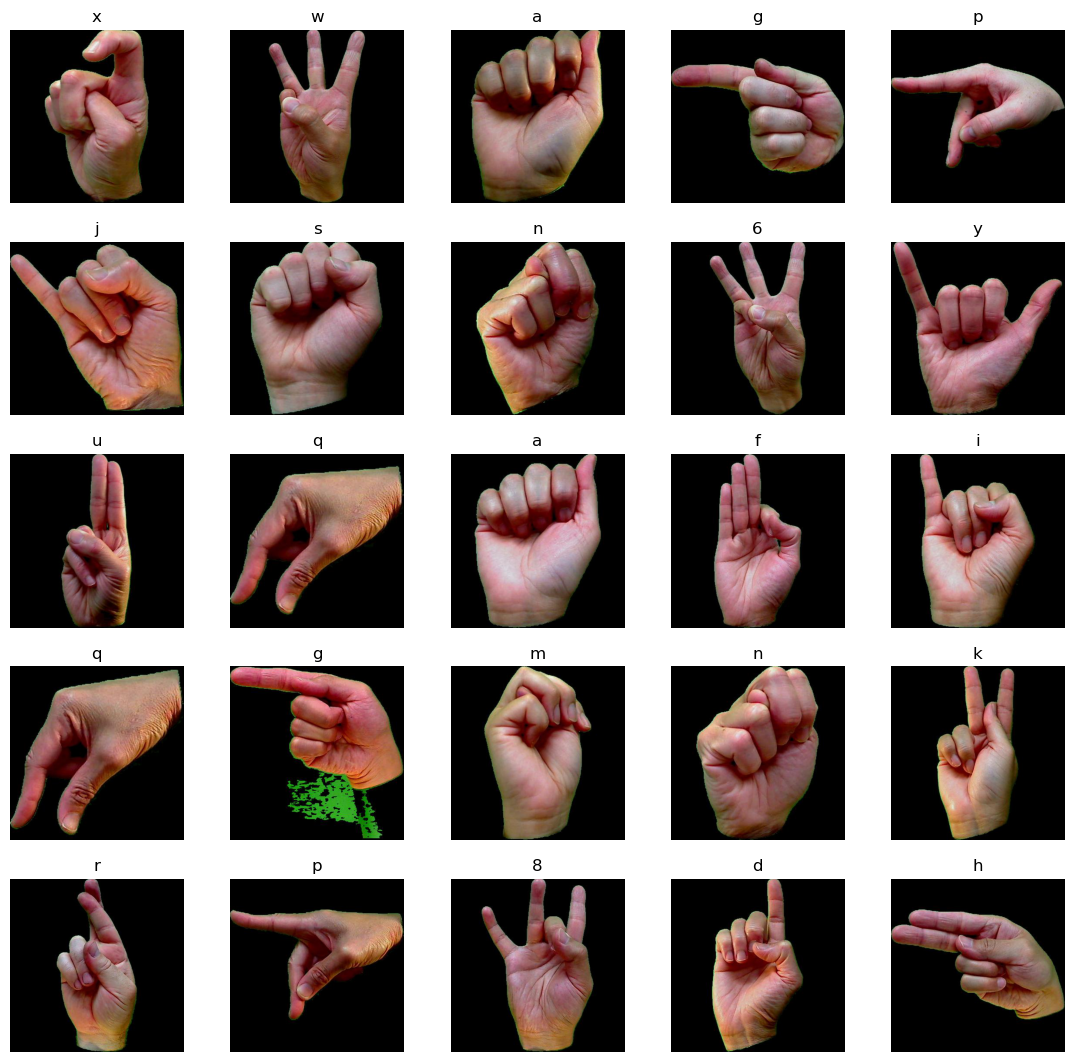

In [6]:
# visualize data
plt.figure(figsize=(11,11))
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    plt.axis('off')
    randval = random.choice(list(categories.values()))
    randimg = imread(data_path + '/' + randval + '/' + random.choice(sorted(os.listdir(data_path + '/' + randval + '/'))))
    plt.imshow(randimg)
    plt.title(randval)

Text(0.5, 1.0, 'Count of Images by Sign')

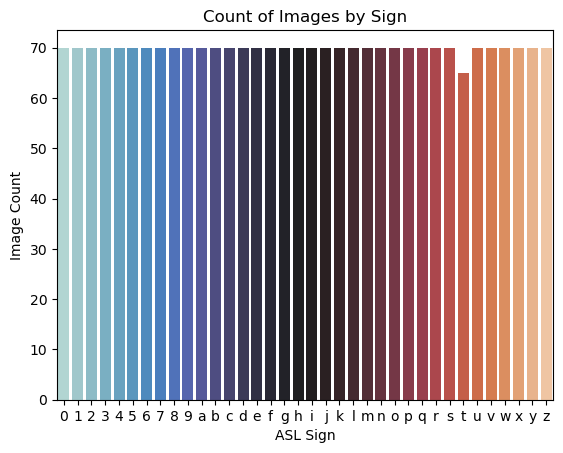

In [7]:
# visualize distribution of images by sign in dataset
sign_freq = df['label'].value_counts().reset_index().sort_values('label')
sns.barplot(sign_freq, x='label', y='count', palette='icefire')
plt.xlabel('ASL Sign')
plt.ylabel('Image Count')
plt.title('Count of Images by Sign')

In [8]:
#Data splitting
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense,Conv2D,Dropout,Flatten,MaxPooling2D, BatchNormalization,Input,concatenate, AveragePooling2D
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix

In [9]:
#Data Preparation
# split dataframe into train, test, and validation
x_train, x_test0, y_train, y_test0 = train_test_split(df['file'], df['label'], test_size=0.25, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test0, y_test0, test_size=0.5, random_state=42)
train = pd.concat([x_train,y_train], axis=1).reset_index(drop=True)
test = pd.concat([x_test,y_test], axis=1).reset_index(drop=True)
val = pd.concat([x_val, y_val], axis=1).reset_index(drop=True)
print(np.shape(train))
print(np.shape(test))
print(np.shape(val))
test

(1886, 2)
(314, 2)
(315, 2)


,file,label
0,asl_dataset/w/hand1_w_right_seg_1_cropped.jpeg,w
1,asl_dataset/n/hand1_n_right_seg_3_cropped.jpeg,n
2,asl_dataset/b/hand5_b_dif_seg_5_cropped.jpeg,b
3,asl_dataset/9/hand5_9_dif_seg_1_cropped.jpeg,9
4,asl_dataset/d/hand2_d_dif_seg_5_cropped.jpeg,d
...,...,...
309,asl_dataset/6/hand1_6_right_seg_1_cropped.jpeg,6
310,asl_dataset/s/hand1_s_dif_seg_4_cropped.jpeg,s
311,asl_dataset/4/hand1_4_right_seg_2_cropped.jpeg,4
312,asl_dataset/w/hand2_w_right_seg_3_cropped.jpeg,w


In [10]:
# normalize image data and transform into train, test, and validation datasets
image_size = 128
batchsize = 32
class_size = 36

datagen = ImageDataGenerator(rescale=1.0/255)

In [11]:

train_data = datagen.flow_from_dataframe(dataframe=train, x_col='file', y_col='label', target_size=(image_size,image_size), batch_size = batchsize, class_mode='categorical')

test_data = datagen.flow_from_dataframe(dataframe=test, x_col='file', y_col='label', target_size=(image_size,image_size), shuffle=False, batch_size=batchsize, class_mode='categorical')

val_data = datagen.flow_from_dataframe(dataframe=val, x_col='file', y_col='label', target_size=(image_size,image_size), shuffle=False, batch_size = batchsize, class_mode='categorical')

Found 1886 validated image filenames belonging to 36 classes.
Found 314 validated image filenames belonging to 36 classes.
Found 315 validated image filenames belonging to 36 classes.


In [12]:
#Convolutional Neural Network
# Initialize model
model = Sequential()

model.add(Conv2D(32, (5,5), activation = 'relu', input_shape = (image_size,image_size,3)))
# model.add(Conv2D(32, 3, activation = 'relu', padding='same'))
model.add(MaxPooling2D(padding='same')) # v3


model.add(Conv2D(64, (5,5), activation = 'relu'))
model.add(MaxPooling2D(padding='same')) # v3

In [13]:

model.add(Flatten())

model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5)) # v3

model.add(Dense(36, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 62, 62, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 53824)             0         
                                                                 
 dense (Dense)               (None, 128)               6

In [14]:
# Initialize callbacks
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, restore_best_weights=True, verbose=0)
reducelr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, verbose=1)

In [15]:
# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train CNN model on training data
classifier = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[earlystop,reducelr], verbose=1) 

Epoch 1/10


59/59 [==============================] - 27s 367ms/step - loss: 2.1684 - accuracy: 0.4263 - val_loss: 0.5576 - val_accuracy: 0.8381 - lr: 0.0010
Epoch 2/10
59/59 [==============================] - 24s 409ms/step - loss: 0.6901 - accuracy: 0.7990 - val_loss: 0.3480 - val_accuracy: 0.9079 - lr: 0.0010
Epoch 3/10
59/59 [==============================] - 21s 347ms/step - loss: 0.3525 - accuracy: 0.8902 - val_loss: 0.2043 - val_accuracy: 0.9460 - lr: 0.0010
Epoch 4/10
59/59 [==============================] - 20s 343ms/step - loss: 0.2704 - accuracy: 0.9104 - val_loss: 0.1882 - val_accuracy: 0.9619 - lr: 0.0010
Epoch 5/10
59/59 [==============================] - 21s 355ms/step - loss: 0.2229 - accuracy: 0.9236 - val_loss: 0.2230 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 6/10
59/59 [==============================] - ETA: 0s - loss: 0.2004 - accuracy: 0.9364
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
59/59 [==============================] - 21s 354

In [17]:
train_loss, train_accuracy = model.evaluate(train_data)
print('Train Accuracy =', train_accuracy*100)
print('Train Loss =', train_loss*100)

59/59 [==============================] - 7s 119ms/step - loss: 0.0045 - accuracy: 0.9979
Train Accuracy = 99.78790879249573
Train Loss = 0.44695460237562656


In [18]:
val_loss, val_accuracy = model.evaluate(val_data)
print('Validation Accuracy =', val_accuracy*100)
print('Validation Loss =', val_loss*100)

10/10 [==============================] - 1s 118ms/step - loss: 0.2227 - accuracy: 0.9587
Validation Accuracy = 95.8730161190033
Validation Loss = 22.27356731891632


In [19]:
test_loss, test_accuracy = model.evaluate(test_data)
print('Test Accuracy =', test_accuracy*100)
print('Test Loss =', test_loss*100)

10/10 [==============================] - 1s 138ms/step - loss: 0.1770 - accuracy: 0.9618
Test Accuracy = 96.17834687232971
Test Loss = 17.700619995594025


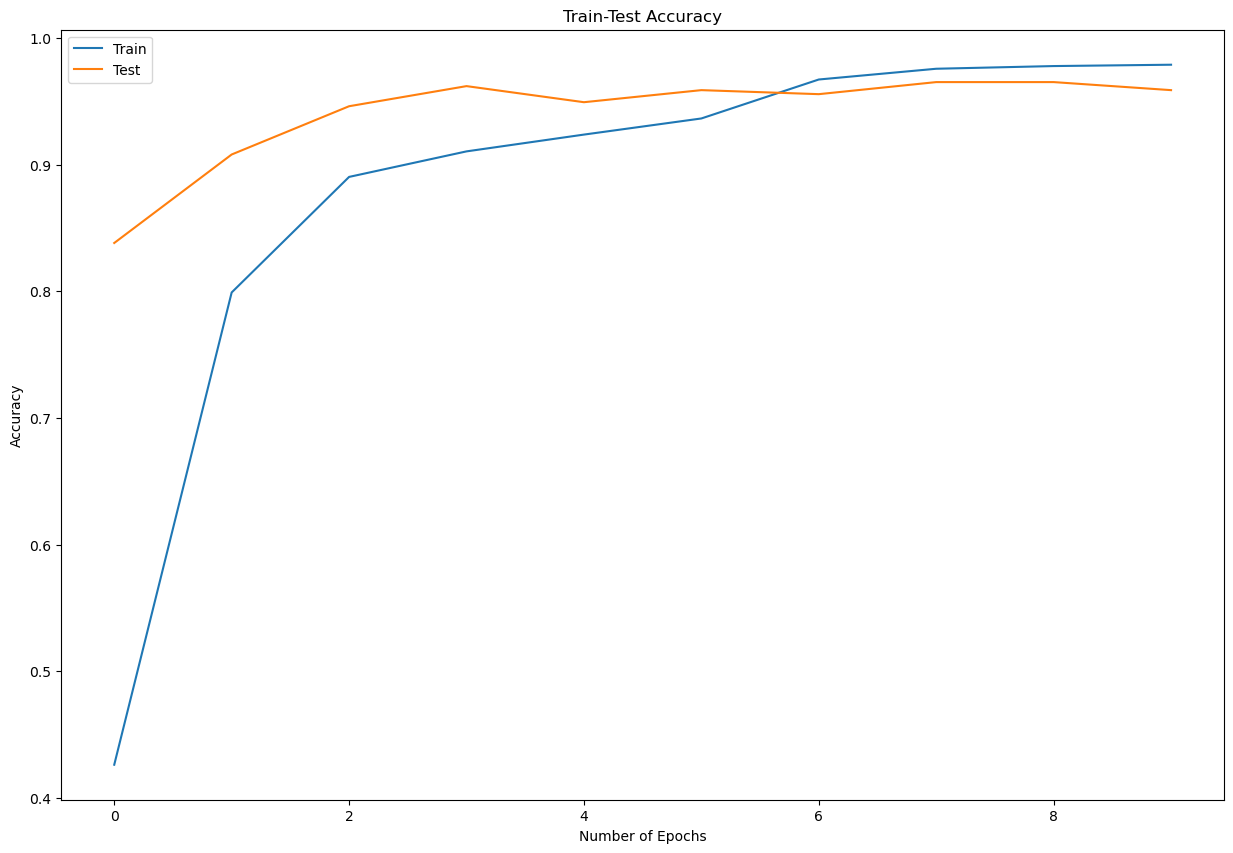

In [20]:
# Visualize accuracy on training and testing groups across epochs
plt.figure(figsize = (15, 10))   
epochs= []
for i in range(10):
    epochs.append(i)
    
plt.plot(epochs,classifier.history['accuracy'], label="Train")
plt.plot(epochs,classifier.history['val_accuracy'], label="Test")
plt.title("Train-Test Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

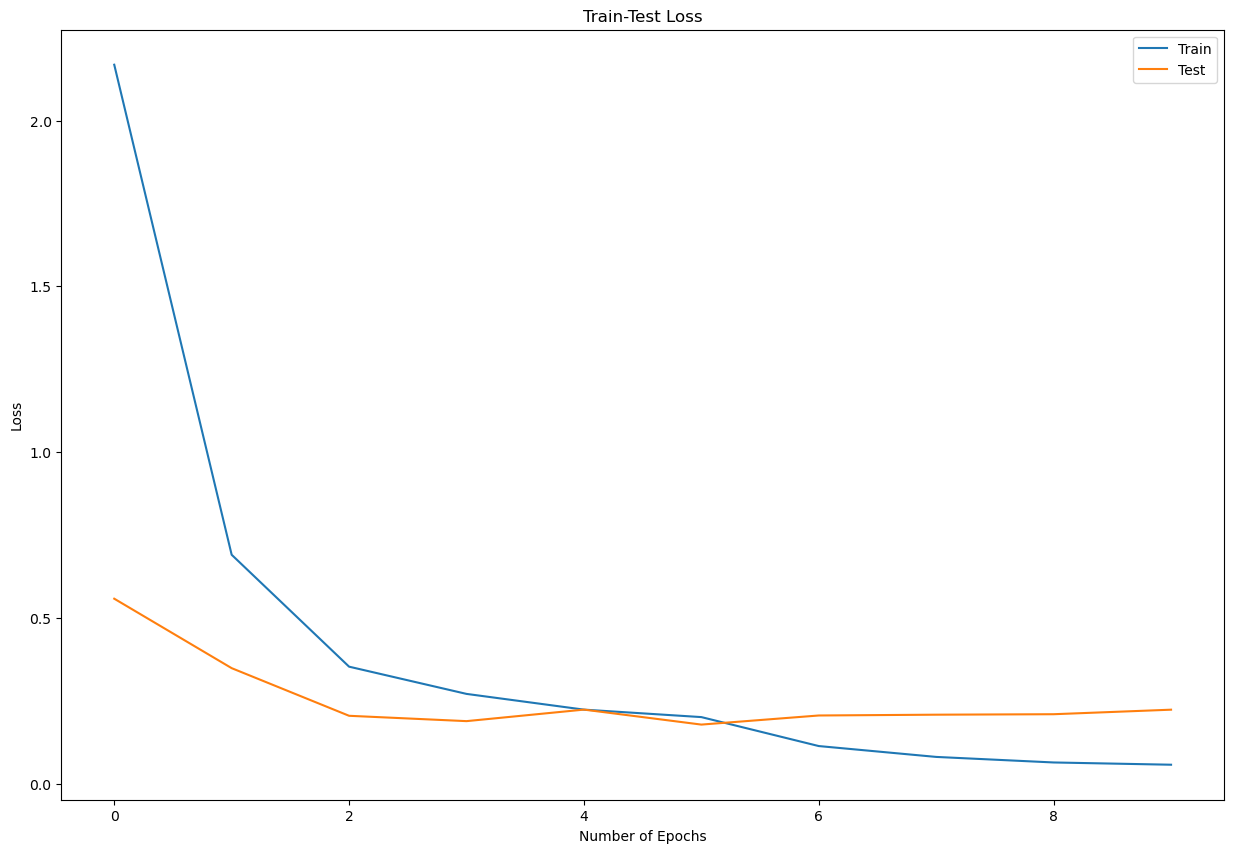

In [21]:
# Visualize loss on training and testing groups across epochs
plt.figure(figsize = (15, 10))   
plt.plot(epochs,classifier.history['loss'], label="Train")
plt.plot(epochs,classifier.history['val_loss'], label="Test")
plt.title("Train-Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [22]:
# Predict on testing dataset and assess accuracy
probs = model.predict(test_data, verbose = 0)
y_pred = np.argmax(probs, axis = 1)
y_actual = test_data.labels

test_loss, test_accuracy = model.evaluate(test_data,verbose = 0)

print('Testing Accuracy:', test_accuracy)
print('Testing Loss:', test_loss, '\n')

correct = np.nonzero(y_pred==y_actual)[0]
incorrect = np.nonzero(y_pred!=y_actual)[0]

print("Correct predicted classes:",correct.shape[0])
print("Incorrect predicted classes:",incorrect.shape[0], '\n')

print(classification_report(y_pred, y_actual))

Testing Accuracy: 0.9617834687232971
Testing Loss: 0.17700619995594025 

Correct predicted classes: 302
Incorrect predicted classes: 12 

              precision    recall  f1-score   support

           0       0.83      0.71      0.77         7
           1       0.88      0.88      0.88         8
           2       0.86      1.00      0.92         6
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         9
           5       1.00      1.00      1.00         5
           6       0.92      0.92      0.92        13
           7       1.00      1.00      1.00         6
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        11
          10       0.89      1.00      0.94         8
          11       0.88      1.00      0.93         7
          12       0.88      1.00      0.93         7
          13       1.00      1.00      1.00         7
          14       1.00      1.00      1.00        

Text(0.5, 1.0, 'Confusion Matrix')

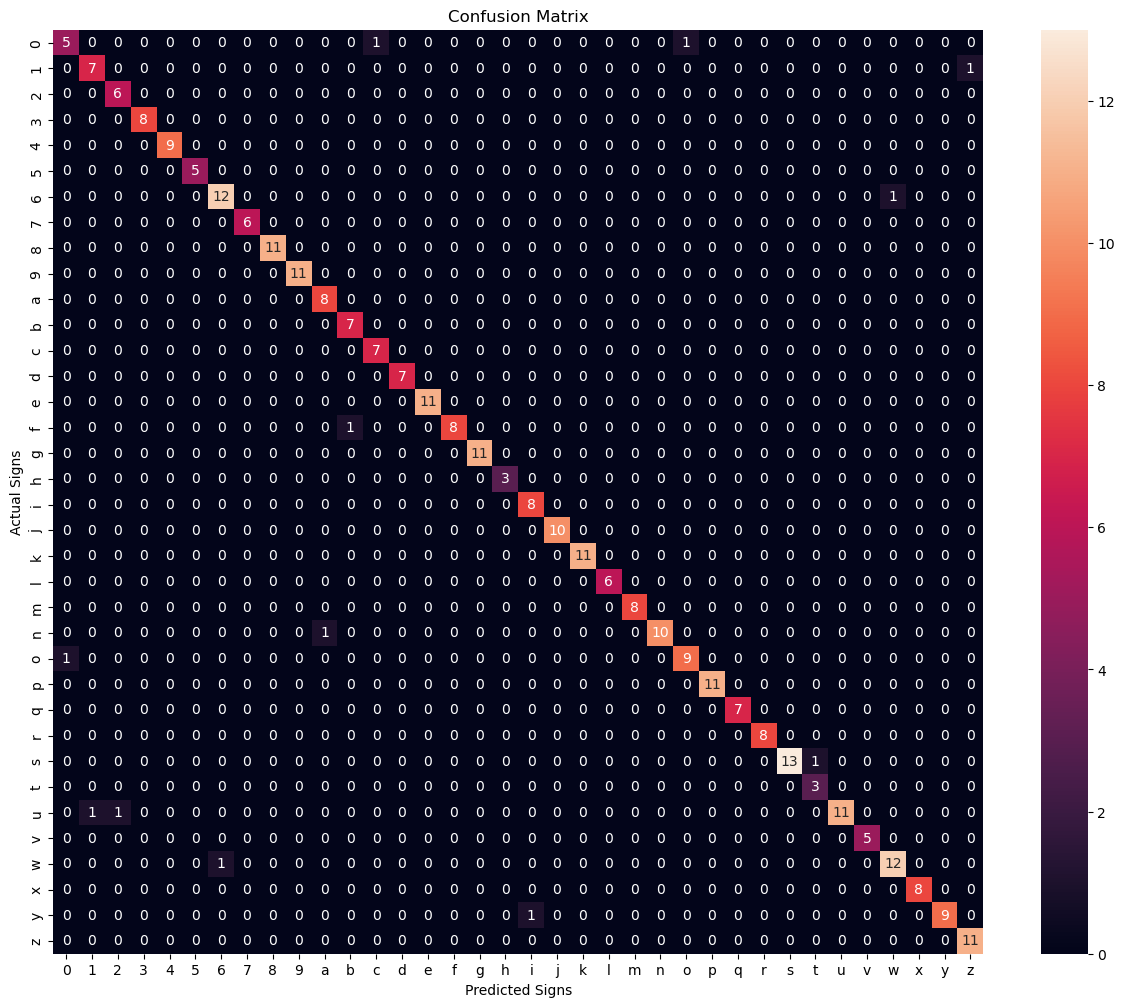

In [23]:
# Visualize confusion matrix of classifications
plt.figure(figsize = (15, 12))   
matrix = confusion_matrix(y_pred, y_actual)
matrixdf = pd.DataFrame(matrix, index=categories.values(), columns=categories.values())
sns.heatmap(matrixdf,annot=True,fmt='g')
plt.xlabel("Predicted Signs")
plt.ylabel("Actual Signs")
plt.title("Confusion Matrix")

In [24]:
# Create reverse dictionary of sign and label
labeldict = {}
for key, value in test_data.class_indices.items():
    labeldict[value] = key

C:\Users\91961\AppData\Local\Temp\ipykernel_9200\1001242162.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


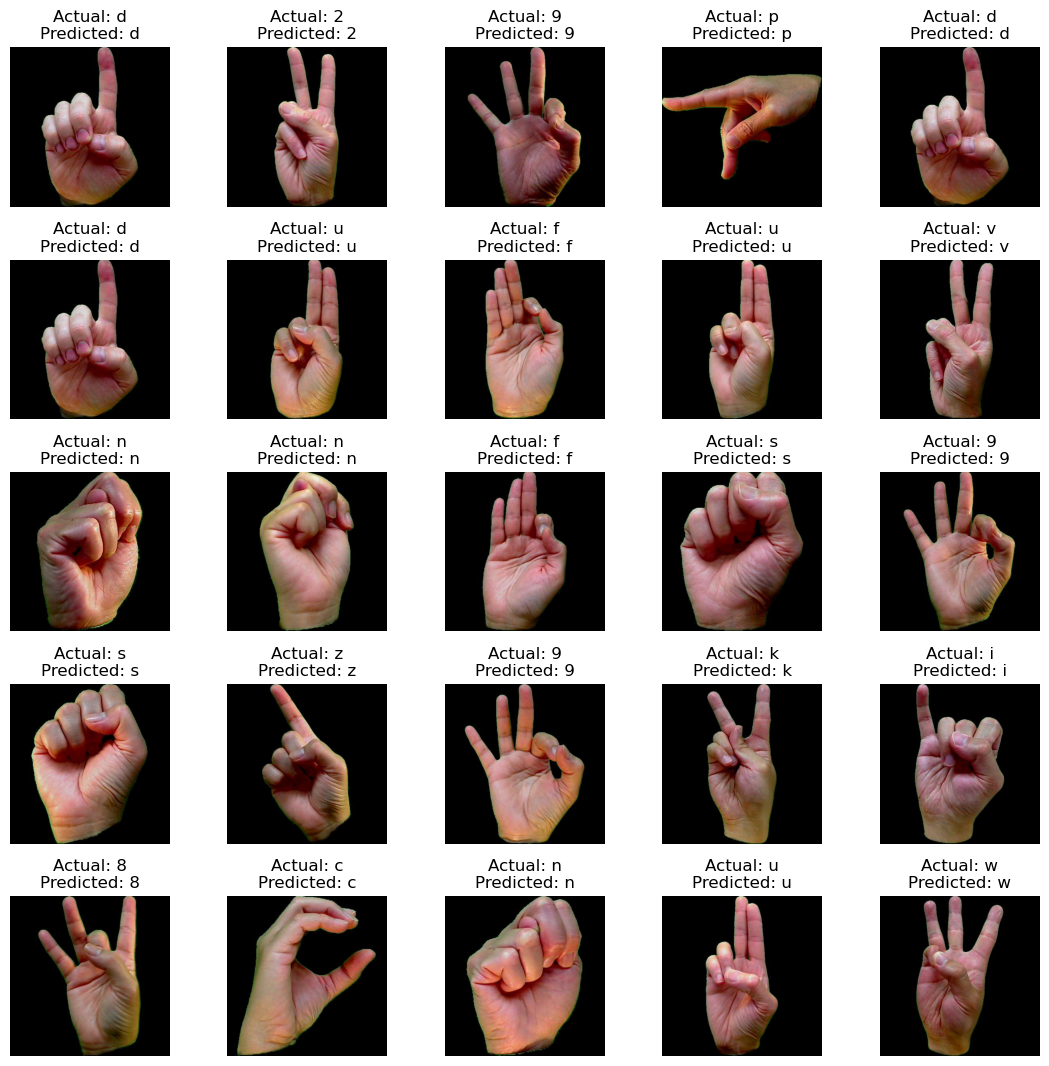

In [25]:
# visualize data predictions
plt.figure(figsize=(11,11))
for i in range(1,26):
    plt.subplot(5,5,i)
    plt.tight_layout()
    plt.axis('off')
    randind = random.randint(0, len(test)-1)
    plt.imshow(imread(test.iloc[randind]['file']))
    plt.title(f"Actual: {labeldict[y_actual[randind]]}\nPredicted: {labeldict[y_pred[randind]]}")

In [26]:
# Save trained model
model.save("model.h5")
trained_model = tf.keras.models.load_model("model.h5")

C:\Users\91961\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
